## Using the CASCADe-jitter package to determine the spectral trace with dithered data ##

This notebook shows the basic functions of the <span style="color:#1F618D">CASCADe-jitter</span> modules to detect and characterize the spectral trace of the dispersed light in spectral data cubes. We demonstrate the use of the Tracer class of the  <span style="color:#1F618D">CASCADe-jitter</span> package on simulated data of the JWST/MIRI Low Resolution Spectrograph (LRS). The <span style="color:#1F618D">CASCADe-jitter</span> package is a sub-package of the <span style="color:#1F618D">CASCADe</span> transit spectroscopy package developed for the H2020 program Exopanets-A, and contains all functionality for detecting pointing jitter in spetroscopic timeseries. 

We start with importing all needed modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii as ap_ascii
import pathlib
import os
from numpy.polynomial.polynomial import polyval

from cascade_filtering.filtering import DirectionalFilter
from cascade_filtering.kernel import FilterKernel

from cascade_jitter.utilities import create_mask_from_dq
from cascade_jitter.utilities import find
from cascade_jitter.jitter import Tracer
from cascade_jitter.initialize import CASCADE_JITTER_EXAMPLE_DIR

%matplotlib inline

Next we defing the path settings to the needed configuration and data files.

In [2]:
CONFIG_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'config_files/'
DATA_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'data/MIRI/LRS/jittered_data/'
CAL_DATA_PATH = pathlib.Path(CASCADE_JITTER_EXAMPLE_DIR) / 'data/MIRI/LRS/calibration_files/'

print(f"The path to the configuration files is: {CONFIG_PATH}")

The path to the configuration files is: /home/bouwman/CASCADeSTORAGE/examples_jitter/config_files


Then we load the simulated data. The used data set consist of 26 integrations, each at a slightly different dither position:

In [3]:
files = find('*_rateints.fits', DATA_PATH)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    print(hdul.info())
    spectral_image_cube = hdul['SCI'].data
    spectral_image_uncertainty = hdul['ERR'].data
    spectral_image_mask = hdul['DQ'].data
spectral_image_cube = spectral_image_cube.astype(float)
spectral_image_uncertainty = spectral_image_uncertainty.astype(float)
spectral_image_mask = create_mask_from_dq(spectral_image_mask.astype(int))

Filename: /home/bouwman/CASCADeSTORAGE/examples_jitter/data/MIRI/LRS/jittered_data/jitter_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        47   (72, 416, 26)   float32   
  2  ERR           1 ImageHDU        11   (72, 416, 26)   float32   
  3  DQ            1 ImageHDU        12   (72, 416, 26)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (72, 416, 26)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (72, 416, 26)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4144B]   
None


For later comparison we also load the file containing for each integration the offset in pixels from the nominal pointing used for the simulated data set.

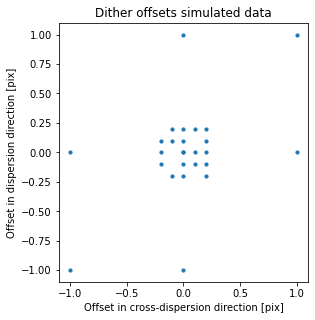

In [4]:
file = 'lrs_dithers.dat'
dither_positions = ap_ascii.read(DATA_PATH / file, names=['xpos', 'ypos']) 
fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.tight_layout(pad=4.0)
ax.scatter(dither_positions['xpos'],dither_positions['ypos'], s=10)
ax.set_title('Dither offsets simulated data')
ax.set_xlabel('Offset in cross-dispersion direction [pix]')
ax.set_ylabel('Offset in dispersion direction [pix]')
plt.show()

Finally we load the calibration file for the LRS instrument, defining the spectral trace and wavelength calibration.

In [5]:
cal_file = 'MIRI_FM_MIRIMAGE_P750L_DISTORTION_07.02.00.fits'
with fits.open(CAL_DATA_PATH / cal_file) as hdul:
    X0 = hdul[0].header['IMXSLTL']
    Y0 = hdul[0].header['IMYSLTL'] - 528
    X_CENTER = hdul[1].data['X_CENTER']-0.5
    Y_CENTER = hdul[1].data['Y_CENTER']-0.5
    WAVELENGTH = hdul[1].data['WAVELENGTH']

Ytrace_calibration = Y0+Y_CENTER
Xtrace_calibration = X0+X_CENTER  

Next we define a region of interest on the detector images in which we will do our analys and seach for the dispersed light of the target star. Note that in this simulation we could have used the entire array but we advice to use prior knowledge to limit the analysis area on the detector to save time and posibly cut out possible problematic data nto needed for the science goals. 

In [6]:
ROI = np.zeros_like(spectral_image_cube[0,...], dtype=bool)
# flag 8 pixels to the left and right of thr subarray
ROI[:, :9] = True
ROI[:, 68:] = True
# flag the top and bottowm parts of the sub array
ROI[:100, :] =True
ROI[-20:, :] =True

The simulated uncalibrated spectra of the bright star contained in the "rateints" fits data file looks like this:

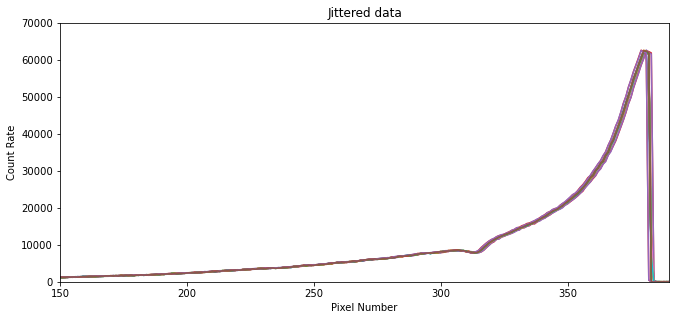

In [7]:
spectra_with_jitter = np.sum(spectral_image_cube*(~ROI).astype(int), axis=2)

fig, ax = plt.subplots(1,1, figsize=(10,5))
fig.tight_layout(pad=4.0)
ax.plot(spectra_with_jitter.T)
ax.set_title('Jittered data')
ax.set_ylim([0, 1.2e5])
ax.set_ylabel('Count Rate')
ax.set_xlabel('Pixel Number')
ax.set_ylim([0, 7e4])
ax.set_xlim([150,390])
plt.show()

Now we made all preparations and have all needed data, we create a tracer object using the 'tracer.conf' file also contained in the examples directory, and run the spectral tracing code on the simulated data.

In [8]:
tracer = Tracer(configuration_file='tracer.conf', configuration_file_path=CONFIG_PATH)
tracer.run_tracer(spectral_image_cube, spectral_image_mask)

We can have a look at the leaded configuration parameters for the tracer object and the used edge filter.

In [9]:
print(f"Configuration of tracer object: {tracer.configuration}")
print(f"Configuration of the edge filter: {tracer.edge_filter_configuration}")

Configuration of tracer object: {'trace_order': 1, 'trace_filter_config_file': 'edge_filter.conf', 'configuration_file_path': PosixPath('/home/bouwman/CASCADeSTORAGE/examples_jitter/config_files')}
Configuration of the edge filter: {'filter_kernel': 'Schar', 'filter_kernel_size': 3, 'filter_verbose': False, 'pre_process_kernel_size': 19, 'pre_process_gaussian_sigma': 3.0, 'low_threshold_ratio': 0.1, 'high_threshold_ratio': 0.1, 'source_extraction_width': 25, 'extension_extraction_height': 2, 'source_treshold': 0.01}


For details on the used edge filter from the <span style="color:#1F618D">CASCADe-filtering</span> package, and how it detect sources and spectral traces,  we refer to the notebooks and documentation of that package. 

The number of detected sources (should be 1), the number of integrations (26) and the derived source mask can be extracted from the tracer object as follows:

In [10]:
number_of_sources = tracer.number_of_sources
print(f"Number of sources {number_of_sources}")

nsource = 0
trace_mask = tracer.source_mask[nsource, ...]

number_of_intergations = trace_mask.shape[0]
print(f"Number of integrations: {number_of_intergations}")

Number of sources 1
Number of integrations: 26


We can plot the masks for 5 of the 26 integrations. Note that these masks are used in the derivation of the spectral trace, and can also be used as extraction apertures. The masks use the numpy.maskedarray convention, i.e. a flagged (True) pixel will not be used.

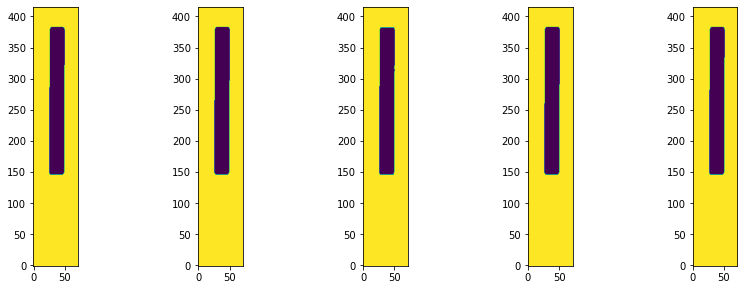

In [11]:
fig, ax = plt.subplots(1,5, figsize=(12,5))
fig.tight_layout(pad=4.0)
ax[0].imshow(trace_mask[0,...], interpolation=None, origin='lower')
ax[1].imshow(trace_mask[5,...], interpolation=None, origin='lower')
ax[2].imshow(trace_mask[10,...], interpolation=None, origin='lower')
ax[3].imshow(trace_mask[15,...], interpolation=None, origin='lower')
ax[4].imshow(trace_mask[25,...], interpolation=None, origin='lower')
plt.show()

We can now look at the derived spectral trace and fitted polinomial coefficients to the derived trace. All the trace information is in the `spectral_traces` attribute of the `tracer' object`. This is an dictionary containing the results from 2 methods. The first method we will look at used the second order derivative (sod) to find the trace. The trace positions and fitted polynomial coefficients are the following: 

In [12]:
trace = tracer.spectral_traces['sod']['trace']
trace_coeff = tracer.spectral_traces['sod']['trace_par']

plot of trace and comparison to calibration file

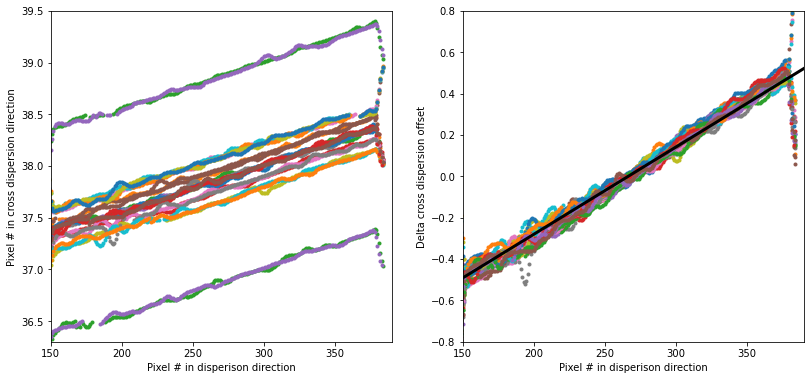

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    X = trace[0][iint][0]
    Y = trace[0][iint][1]
    ax[0].plot(Y,X,'.')
    ax[1].plot(Y,X-np.median(X),'.')
ax[1].plot(Ytrace_calibration, Xtrace_calibration-np.median(Xtrace_calibration[10:250]), color='black',
           lw=3, label='Calibration file')
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([150, 390])
ax[1].set_ylim([-0.8,0.8])
ax[1].set_xlim([150, 390])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Pixel # in disperison direction")
ax[1].set_ylabel("Delta cross dispersion offset")
plt.show()

plot of trace from fitted polynomials and comparison to imput cross dispersion offset dither

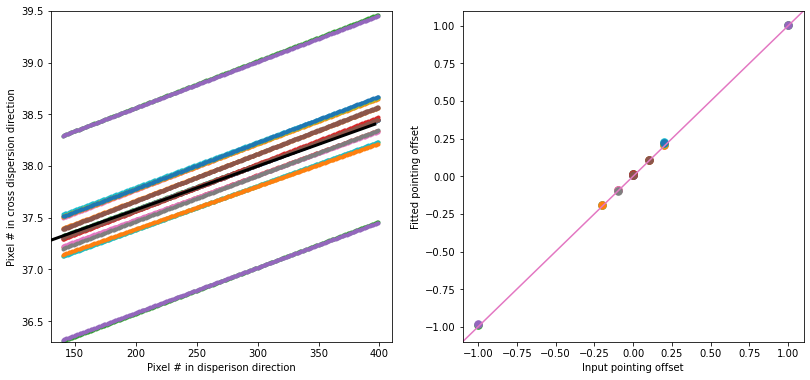

In [14]:
Y = np.arange(140, 400)
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    coeff = trace_coeff[0][iint]
    #Y = trace[0][iint][1]
    X = polyval(Y, coeff)
    ax[0].plot(Y,X,'.')
    ax[1].plot(dither_positions['xpos'][iint], np.median(X)-37.87, '.', ms=15)
ax[0].plot(Ytrace_calibration, Xtrace_calibration, color='black',lw=3, label='Calibration file')
ax[1].plot([-1.1, 1.1], [-1.1, 1.1])
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([130, 410])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_xlim([-1.1, 1.1])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Input pointing offset")
ax[1].set_ylabel("Fitted pointing offset")
plt.show()

Center of light (col) trace and fitted plynomial coefficients.

In [15]:
trace_col = tracer.spectral_traces['col']['trace']
trace_coeff_col = tracer.spectral_traces['col']['trace_par']

Plot spectral trace and comparison to calibration file

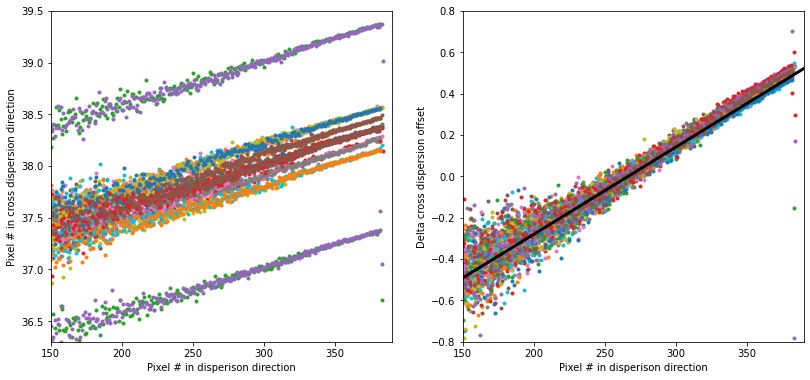

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    X = trace_col[0][iint][0]
    Y = trace_col[0][iint][1]
    ax[0].plot(Y,X,'.')
    ax[1].plot(Y,X-np.median(X),'.')
ax[1].plot(Ytrace_calibration, Xtrace_calibration-np.median(Xtrace_calibration[10:250]), color='black',
           lw=3, label='Calibration file')
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([150, 390])
ax[1].set_ylim([-0.8,0.8])
ax[1].set_xlim([150, 390])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Pixel # in disperison direction")
ax[1].set_ylabel("Delta cross dispersion offset")
plt.show()

plot result of polynomial fit and comparisson to used dither offsets

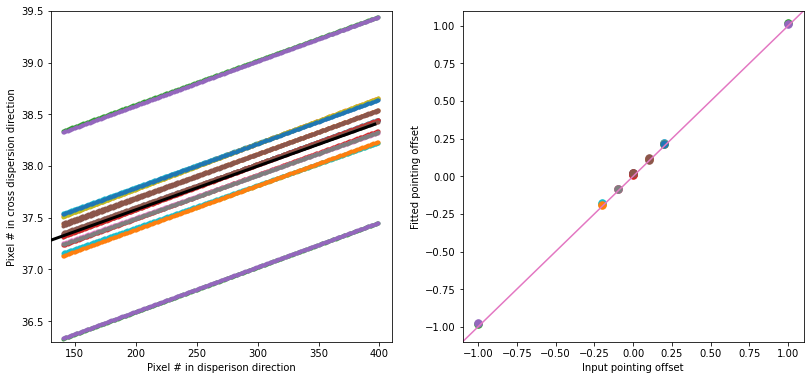

In [17]:
Y = np.arange(140, 400)
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    coeff = trace_coeff_col[0][iint]
    #Y = trace[0][iint][1]
    X = polyval(Y, coeff)
    ax[0].plot(Y,X,'.')
    ax[1].plot(dither_positions['xpos'][iint], np.median(X)-37.87, '.', ms=15)
ax[0].plot(Ytrace_calibration, Xtrace_calibration, color='black',lw=3, label='Calibration file')
ax[1].plot([-1.1, 1.1], [-1.1, 1.1])
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([130, 410])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_xlim([-1.1, 1.1])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Input pointing offset")
ax[1].set_ylabel("Fitted pointing offset")
plt.show()

## Using 2D anisotropic filtering before determining the spectral trace with dithered data ##
We can also look a the effect of bad pixel masking and cleaning of the spectral images has on the trace determinations. In case of strong cosmic hits (not the case for the used data set) this probably will be the best option to make sure the strong signals of the cosmic hits do not influence the determination of the partial derivatives or center of light needed to measure the spectral trace. 

For details on the use of the <span style="color:#1F618D">CASCADe-filtering</span> package we refer to the notebooks and documentation of that package. To filter the spectral images, we first define a stack of filter kernels. Here we use the standard <span style="color:#1F618D">CASCADe</span> 2D filter kernel

In [18]:
FK = FilterKernel(configuration_file='banana_kernel.conf', path=CONFIG_PATH)
KERNEL_STACK = FK.kernel_stack

Next we create the directional filter kernel object and run the filtering on the spectral image cubes

In [19]:
DF = DirectionalFilter(sigma=4.0, max_iterations=39, acceptance_treshold=0.0001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 5066
iteration: 2, number of flagged pixel: 10278
iteration: 3, number of flagged pixel: 2423
iteration: 4, number of flagged pixel: 863
iteration: 5, number of flagged pixel: 295
iteration: 6, number of flagged pixel: 109
iteration: 7, number of flagged pixel: 56
Final number of still flagged pixel after iterations: 25
The acceptance limit is: 45


The new pixel mask, the filtered data and the cleaned data can now be extracted from the DirectionalFilter

In [20]:
new_bad_pixel_mask = DF.return_updated_mask()
cleaned_image_cube, cleaned_image_cube_uncertainty, cleaned_image_cube_mask = DF.return_cleaned_data()
filtered_image_cube, filtered_image_cube_uncertainty, filtered_image_cube_mask = DF.return_filtered_data()

Next we create again a Tracer class instance and use the cleaned dataset in the trace determination:

In [21]:
tracer = Tracer(configuration_file='tracer.conf', configuration_file_path=CONFIG_PATH)
tracer.run_tracer(cleaned_image_cube, cleaned_image_cube_mask)

The spectral trace and fitted polynomial coefficients:

In [22]:
trace = tracer.spectral_traces['sod']['trace']
trace_coeff = tracer.spectral_traces['sod']['trace_par']

plot of trace

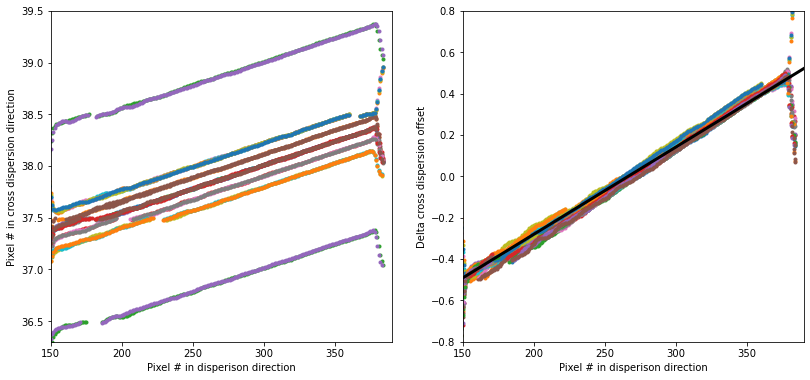

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
Xall = []
Yall = []
for iint in range(26):
    X = trace[0][iint][0]
    Xall += list(X)
    Y = trace[0][iint][1]
    Yall += list(Y)
    ax[0].plot(Y,X,'.')
    ax[1].plot(Y,X-np.median(X),'.')
ax[1].plot(Ytrace_calibration, Xtrace_calibration-np.median(Xtrace_calibration[10:250]), color='black',
           lw=3, label='Calibration file')
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([150, 390])
ax[1].set_ylim([-0.8,0.8])
ax[1].set_xlim([150, 390])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Pixel # in disperison direction")
ax[1].set_ylabel("Delta cross dispersion offset")
plt.show()

Trace from fitted polynomials

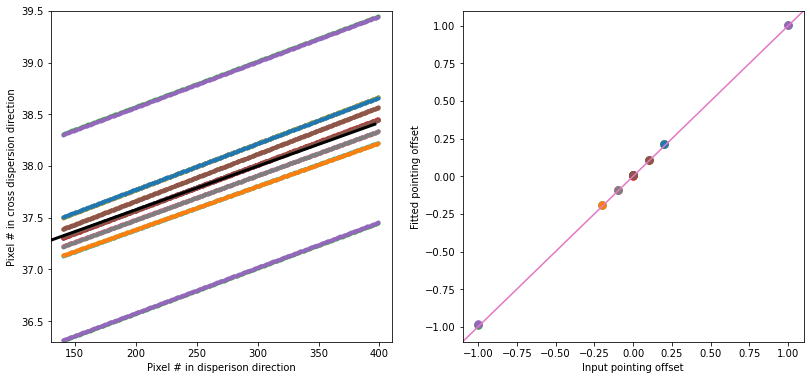

In [24]:
Y = np.arange(140, 400)
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    coeff = trace_coeff[0][iint]
    #Y = trace[0][iint][1]
    X = polyval(Y, coeff)
    ax[0].plot(Y,X,'.')
    ax[1].plot(dither_positions['xpos'][iint], np.median(X)-37.87, '.', ms=15)
ax[0].plot(Ytrace_calibration, Xtrace_calibration, color='black',lw=3, label='Calibration file')
ax[1].plot([-1.1, 1.1], [-1.1, 1.1])
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([130, 410])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_xlabel("Input pointing offset")
ax[1].set_ylabel("Fitted pointing offset")
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
plt.show()

Using the center of light

In [25]:
trace_col = tracer.spectral_traces['col']['trace']
trace_coeff_col = tracer.spectral_traces['col']['trace_par']

plot

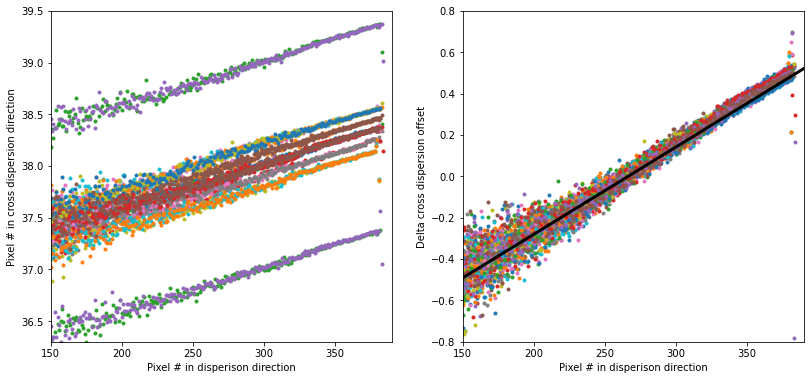

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
Xall = []
Yall = []
for iint in range(26):
    X = trace_col[0][iint][0]
    Xall += list(X)
    Y = trace_col[0][iint][1]
    Yall += list(Y)
    ax[0].plot(Y,X,'.')
    ax[1].plot(Y,X-np.median(X),'.')
ax[1].plot(Ytrace_calibration, Xtrace_calibration-np.median(Xtrace_calibration[10:250]), color='black',
           lw=3, label='Calibration file')
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([150, 390])
ax[1].set_ylim([-0.8,0.8])
ax[1].set_xlim([150, 390])
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
ax[1].set_xlabel("Pixel # in disperison direction")
ax[1].set_ylabel("Delta cross dispersion offset")
plt.show()

plot with polynomial fit

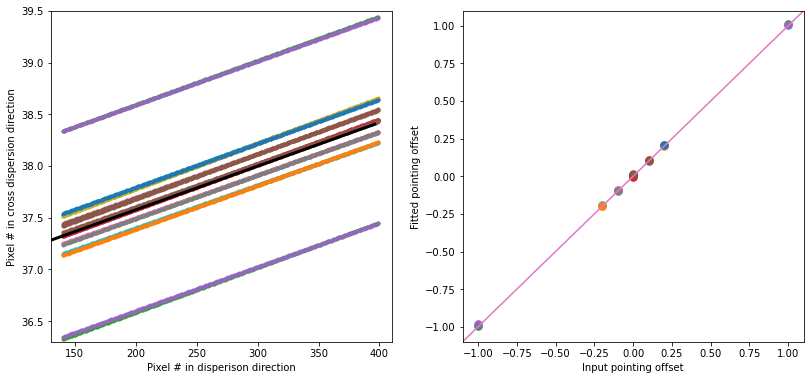

In [27]:
Y = np.arange(140, 400)
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(pad=4.0)
for iint in range(26):
    coeff = trace_coeff_col[0][iint]
    #Y = trace[0][iint][1]
    X = polyval(Y, coeff)
    ax[0].plot(Y,X,'.')
    ax[1].plot(dither_positions['xpos'][iint], np.median(X)-37.88, '.', ms=15)
ax[0].plot(Ytrace_calibration, Xtrace_calibration, color='black',lw=3, label='Calibration file')
ax[1].plot([-1.1, 1.1], [-1.1, 1.1])
ax[0].set_ylim([36.3, 39.5])
ax[0].set_xlim([130, 410])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_xlabel("Input pointing offset")
ax[1].set_ylabel("Fitted pointing offset")
ax[0].set_xlabel("Pixel # in disperison direction")
ax[0].set_ylabel("Pixel # in cross dispersion direction")
plt.show()